# Netflix Prize Movie Recommendation Project

100M ratings released to the public
17770 movies and 480,000 users
4 datasets

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
dataset = pd.read_csv('combined_data_1.txt',header = None, names=['Cust_id','Rating'],usecols=[0,1])

# header = None, so that the 1st row is not treated as column names or header
# names = names we want to use for columns
# usecols = [0,1] because we only want to use the first 2 columns. 3rd column is dates that we don't need.
# So only column 1 and 2 are imported.

In [3]:
dataset.head()

,Cust_id,Rating
0,1:,NaN
1,1488844,3.0
2,822109,5.0
3,885013,4.0
4,30878,4.0


In [4]:
dataset.dtypes

Cust_id     object
Rating     float64
dtype: object

In [5]:
#dataset['Rating'] = dataset['Rating'].astype(float)
# Use this command if the ratings are not float 64 already

In [6]:
dataset.shape

(24058263, 2)

In [7]:
# For ratings 1 to 5, how many users have given that particular rating
# So, we are using groupby Ratings

p = dataset.groupby('Rating')['Rating'].agg(['count'])
p

,count
Rating,
1.0,1118186
2.0,2439073
3.0,6904181
4.0,8085741
5.0,5506583


In [8]:
# Rating column for a movie number is Nan. Only the customer ids have corresponding ratings.
# So, whatever rows contain Nan, have the movie number.
# Ex, row 1 has values 1 and Nan. Then, row 549 has values 2 and Nan and so on.
# We can calculate total number of movies using this relation.
# Total number of NaN values = Total number of movies in our dataset.

movie_count = dataset.isnull().sum()[1]
movie_count

# We are using index as 1 because there are no NaN valus in Cust_id and we are not interested in that column.
# We only want the total Nan count for ratings column.

4499

In [9]:
# Get customer count
cust_count = dataset['Cust_id'].nunique() - movie_count
cust_count

470758

In [10]:
# Get rating count

rating_count = dataset['Cust_id'].count() - movie_count

rating_count

24053764

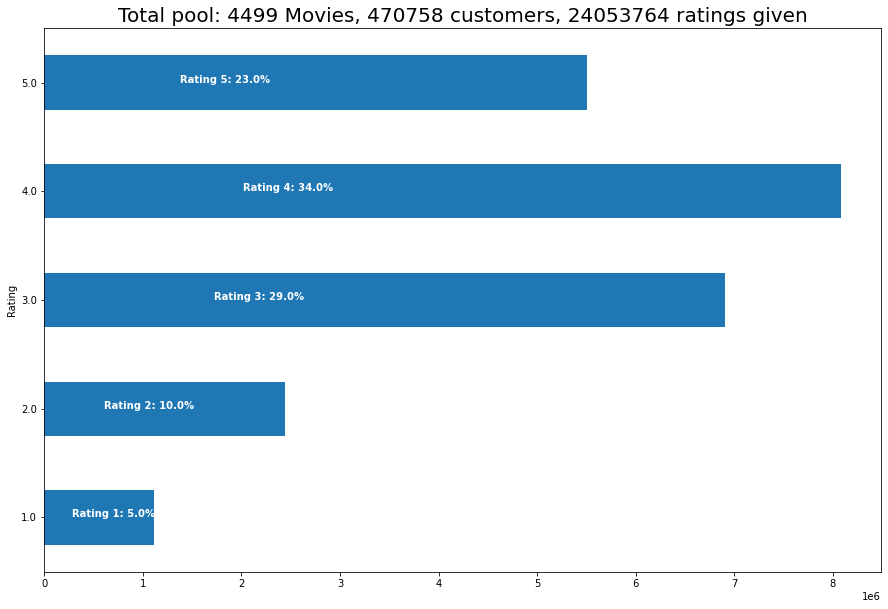

In [11]:
ax = p.plot(kind='barh', legend = False, figsize=(15,10))
plt.title(f'Total pool: {movie_count} Movies, {cust_count} customers, {rating_count} ratings given', fontsize = 20)

for i in range(1,6):
    ax.text(p.iloc[i-1][0]/4, i-1, f'Rating {i}: {round(p.iloc[i-1][0]*100/p.sum()[0],0)}%', color ='white', weight ='bold')

In [12]:
# Add movie id in front of the cust_id and ratings so that we know for what movie the rating is.

df_nan = pd.DataFrame(pd.isnull(dataset.Rating),)
df_nan.head()

,Rating
0,True
1,False
2,False
3,False
4,False


In [13]:
df_nan.shape

(24058263, 1)

In [14]:
# Select only those indexes where Nan rating is true.
# That means, we are reducing the size of df_nan by working with only those rows which are actually movies.
df_nan = df_nan[df_nan['Rating']==True]

df_nan.shape

df_nan.head()

,Rating
0,True
548,True
694,True
2707,True
2850,True


In [15]:
# We dont want the indexes for movies treated as indexes for df_nan.
# So, we reset the index of df_nan. Movie indexes becomes a new column and df_nan gets new row numbers as indexes.
df_nan = df_nan.reset_index()

df_nan.head()

,index,Rating
0,0,True
1,548,True
2,694,True
3,2707,True
4,2850,True


In [16]:
movie_np =[]
movie_id = 1

# The zip function pairs the first elements of each iterator together, then pairs the second elements together and so on.
# If the iterables in the zip function are not the same length, then the smallest length iterable decides the length of the generated output.

for i, j in zip(df_nan['index'][1:],df_nan['index'][0:]):
    #numpy approach
    # numpy.full(shape, fill_value, dtype=None, order='C', *, like=None)
    # Returns a new array of given shape and type, filled with fill_value.
    temp = np.full((1,i-j-1),movie_id)
    movie_np =np.append(movie_np,temp)
    movie_id += 1
    
# Account for last record and corresponding length
# numpy approach

# Shape of the last record is one column with no.of rows calculated as - 
# total no. of rows - last record of df_nan - 1 (as 1 row is for movie number and not the actual rating).

last_record = np.full((1,len(dataset) - df_nan.iloc[-1,0] -1), movie_id)
movie_np = np.append(movie_np, last_record)

print(f'Movie numpy: {movie_np}')
print(f'Length: {len(movie_np)}')

Movie numpy: [1.000e+00 1.000e+00 1.000e+00 ... 4.499e+03 4.499e+03 4.499e+03]
Length: 24053764


In [17]:
# Now drop the Nan rows because we already have movie ids in movie_np

dataset = dataset[pd.notnull(dataset['Rating'])]

# Add a new column to dataset for movie_id as int.
dataset['Movie_id'] = movie_np.astype(int)

# Convert Cust_id from object to int.
dataset['Cust_id'] = dataset['Cust_id'].astype(int)

dataset.head()

,Cust_id,Rating,Movie_id
1,1488844,3.0,1
2,822109,5.0,1
3,885013,4.0,1
4,30878,4.0,1
5,823519,3.0,1


In [18]:
dataset.shape

(24053764, 3)

In [19]:
f = ['count', 'mean']

dataset_movie_summary = dataset.groupby('Movie_id')['Rating'].agg(f)

dataset_movie_summary.index = dataset_movie_summary.index.map(int)

# 0.7 quantile means 70% of the data is below this value.
# 0.7 quantile of count od ratings is 1799.
# that means, we are going to consider only those movies which have been rated by atleast 1799 users.

movie_benchmark = round(dataset_movie_summary['count'].quantile(0.7),0)

# Store the indexes of movies reviewed less than 1799 times, so that we can remove those movies from the dataset later.
drop_movie_list = dataset_movie_summary[dataset_movie_summary['count'] < movie_benchmark].index

print(f'Movie minimum times of review: {movie_benchmark}')

Movie minimum times of review: 1799.0


In [20]:
# To remove inactive users from dataset

dataset_cust_summary = dataset.groupby('Cust_id')['Rating'].agg(f)

dataset_cust_summary.index = dataset_cust_summary.index.map(int)

# 0.7 quantile for customer's rating is 52. 
# So, here we are going to consider only those customers who have reviewed more than 52 movies.

cust_benchmark = round(dataset_cust_summary['count'].quantile(0.7),0)

drop_cust_list = dataset_cust_summary[dataset_cust_summary['count'] < cust_benchmark].index

print(f'Customer minimum times of review: {cust_benchmark}')

Customer minimum times of review: 52.0


In [21]:
print(f'Original Shape: {dataset.shape}')

Original Shape: (24053764, 3)


In [22]:
# Remove movies and customers in 0.7 quantile.
# This will make our dataset smaller and recommendation model stronger.

# ~ sign means exclude these records.
dataset = dataset[~dataset['Movie_id'].isin(drop_movie_list)]
dataset = dataset[~dataset['Cust_id'].isin(drop_cust_list)]

print(f'After Trim Shape: {dataset.shape}')

After Trim Shape: (17337458, 3)


In [23]:
dataset.head()

,Cust_id,Rating,Movie_id
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
700,656399,4.0,3


In [24]:
# We are going to use SVD (Singular Value Decomposition) algo for the recommendation system.
# This algo takes sparse matrix as an input.
# We are going to create a sparse matrix using pivot_table method of pandas.
# Here, Cust_ids will be the rows, Movie_ids will be the columns and Ratings will be the values.
# As not every customer has reviewed every movie, many values will be NaNs. So, the matrix will be sparse.

df_p =pd.pivot_table(dataset, values = "Rating", index = 'Cust_id', columns = 'Movie_id')

print(df_p.shape)

(143458, 1350)


In [25]:
df_p.head()

Movie_id,3,8,16,17,18,26,28,30,32,33,...,4472,4474,4478,4479,4485,4488,4490,4492,4493,4496
Cust_id,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,5.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,...,3.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN
79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN
97,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
134,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
df_title = pd.read_csv('movie_titles.csv',error_bad_lines=False, encoding = "ISO-8859-1", header = None, names = ['Movie_id','Year','Name'])

df_title.set_index('Movie_id', inplace = True)

print(df_title.head(10))

C:\Users\piyus\AppData\Local\Temp\ipykernel_17968\2810715885.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  df_title = pd.read_csv('movie_titles.csv',error_bad_lines=False, encoding = "ISO-8859-1", header = None, names = ['Movie_id','Year','Name'])


            Year                          Name
Movie_id                                      
1         2003.0               Dinosaur Planet
2         2004.0    Isle of Man TT 2004 Review
3         1997.0                     Character
4         1994.0  Paula Abdul's Get Up & Dance
5         2004.0      The Rise and Fall of ECW
6         1997.0                          Sick
7         1992.0                         8 Man
8         2004.0    What the #$*! Do We Know!?
9         1991.0      Class of Nuke 'Em High 2
10        2001.0                       Fighter


b'Skipping line 72: expected 3 fields, saw 4\nSkipping line 264: expected 3 fields, saw 5\nSkipping line 350: expected 3 fields, saw 4\nSkipping line 366: expected 3 fields, saw 4\nSkipping line 394: expected 3 fields, saw 4\nSkipping line 466: expected 3 fields, saw 4\nSkipping line 582: expected 3 fields, saw 4\nSkipping line 600: expected 3 fields, saw 4\nSkipping line 670: expected 3 fields, saw 4\nSkipping line 672: expected 3 fields, saw 4\nSkipping line 729: expected 3 fields, saw 4\nSkipping line 776: expected 3 fields, saw 4\nSkipping line 827: expected 3 fields, saw 4\nSkipping line 834: expected 3 fields, saw 4\nSkipping line 891: expected 3 fields, saw 4\nSkipping line 913: expected 3 fields, saw 4\nSkipping line 944: expected 3 fields, saw 4\nSkipping line 973: expected 3 fields, saw 4\nSkipping line 1010: expected 3 fields, saw 4\nSkipping line 1015: expected 3 fields, saw 4\nSkipping line 1058: expected 3 fields, saw 4\nSkipping line 1095: expected 3 fields, saw 4\nSkipp

In [27]:
df_title.shape

(17434, 2)

In [28]:
import math
import re
from scipy.sparse import csr_matrix
import seaborn as sns

from surprise import Reader, Dataset, SVD
from surprise.model_selection import cross_validate

In [30]:
reader = Reader()

#Consider only top 100K rows for faster run time

data = Dataset.load_from_df(dataset[['Cust_id','Movie_id','Rating']][:100000],reader)

svd = SVD()

cross_validate(svd,data, measures=['RMSE','MAE'], cv=3, verbose= True)


Evaluating RMSE, MAE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.9901  1.0006  1.0026  0.9978  0.0055  
MAE (testset)     0.8031  0.8127  0.7994  0.8051  0.0056  
Fit time          3.82    3.70    3.73    3.75    0.05    
Test time         0.28    0.18    0.19    0.22    0.04    


{'test_rmse': array([0.99009887, 1.00056838, 1.00264733]),
 'test_mae': array([0.80314627, 0.81266518, 0.79938857]),
 'fit_time': (3.8203375339508057, 3.697636365890503, 3.7265892028808594),
 'test_time': (0.27687883377075195, 0.18388748168945312, 0.1948549747467041)}

In [31]:
dataset.head()

,Cust_id,Rating,Movie_id
696,712664,5.0,3
697,1331154,4.0,3
698,2632461,3.0,3
699,44937,5.0,3
700,656399,4.0,3


In [32]:
dataset_712664 = dataset[(dataset['Cust_id']==712664) & (dataset['Rating']==5)]
dataset_712664 = dataset_712664.set_index('Movie_id')
dataset_712664 = dataset_712664.join(df_title)['Name']
dataset_712664.head(10)

Movie_id
3                              Character
79                           The Killing
175                       Reservoir Dogs
199                      The Deer Hunter
241                   North by Northwest
256    Ghost Dog: The Way of the Samurai
348        The Last Temptation of Christ
357                House of Sand and Fog
416                             Elephant
442                  Mississippi Burning
Name: Name, dtype: object

In [33]:
user_712664 = df_title.copy()

user_712664 = user_712664.reset_index()

user_712664 = user_712664[~user_712664['Movie_id'].isin(drop_movie_list)]

# Getting full dataset

data = Dataset.load_from_df(dataset[['Cust_id','Movie_id','Rating']], reader)

trainset = data.build_full_trainset()
svd.fit(trainset)

user_712664['Estimated_Score'] = user_712664['Movie_id'].apply(lambda x: svd.predict(712664,x).est)

user_712664 = user_712664.drop('Movie_id', axis = 1)

user_712664 = user_712664.sort_values('Estimated_Score', ascending = False)

print(user_712664.head(10))

        Year                                      Name  Estimated_Score
173   1992.0                            Reservoir Dogs         5.000000
857   1954.0                             Seven Samurai         5.000000
711   2003.0                        The Wire: Season 1         5.000000
1252  1988.0                       Red Dwarf: Series 3         5.000000
977   1961.0                                   Yojimbo         4.975829
3979  1990.0  House of Cards Trilogy I: House of Cards         4.927827
2389  1979.0                Alien: Collector's Edition         4.926896
4270  2002.0            Curb Your Enthusiasm: Season 3         4.926205
1011  1992.0                               Hard Boiled         4.913559
570   1961.0                The Twilight Zone: Vol. 36         4.912624
